### Import required Libraries 

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
#!pip install geocoder
import geocoder
#!pip install folium
import folium
#!pip install geopy
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

### Read New York city data with boroughs and neighborhoods 

In [3]:
url = 'https://cocl.us/new_york_dataset'
resp = requests.get(url).json()
features = resp['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
ny_data = pd.DataFrame(columns = column_names)
for data in features:
    borough = data['properties']['borough']
    neighborhood = data['properties']['name']
    coordinates = data['geometry']['coordinates']
    lat = coordinates[1]
    log = coordinates[0]
    ny_data = ny_data.append({'Borough': borough,
                             'Neighborhood':neighborhood,
                             'Latitude': lat,
                             'Longitude': log},
                            ignore_index=True)
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
ny_data.shape

(306, 4)

There are 306 neighborhood in New York

### Bar chart representing number of neighborhoods in each Borough

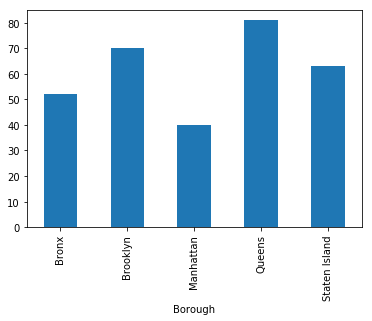

In [5]:
ny_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')

### Function to get venues of respective location using latitude, longitude using Foursquare API

In [7]:
def get_venues(lat,lng):
    client_id = 'GTKRAKX22WEMCG3TVQF24QLTTNPR2EOO5TDMMLOWQNNNXOTH'
    client_secret = 'U32ESHRW4VZHWXJBDV50PME1UAEASIGKGE54YE3ALLIO311O'
    version = '20200707'
    radius = 1000
    LIMIT = 100
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    results = requests.get(url).json()
    results
    venues_data=[]
    try:
        venues_data = results['response']['groups'][0]['items']
        #print("Success")
    except:
        pass
    venue_details= []
    for row in venues_data:
        try:
            venue_id = row['venue']['id']
            venue_name = row['venue']['name']
            venue_category = row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except:
            pass
    column_names = ['ID','Name','Category']
    df_venue = pd.DataFrame(venue_details,columns=column_names)
    
    return df_venue


In [8]:
column_names=['Borough','Neighborhood','ID','Name']
indian_rest_ny = pd.DataFrame(columns=column_names)
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude, Longitude)
    indian_rest = venues[venues['Category']=='Indian Restaurant']
    
    for rest in indian_rest.values.tolist():
        id, name, category = rest
        indian_rest_ny = indian_rest_ny.append({'Borough':Borough,
                                               'Neighborhood':Neighborhood,
                                               'ID' : id,
                                               'Name' : name
                                               }, ignore_index=True
        )


From cffi callback <function _verify_callback at 0x00000206A0C36950>:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\OpenSSL\SSL.py", line 221, in wrapper
    @wraps(callback)
KeyboardInterrupt


SSLError: HTTPSConnectionPool(host='api.foursquare.com', port=443): Max retries exceeded with url: /v2/venues/explore?&client_id=GTKRAKX22WEMCG3TVQF24QLTTNPR2EOO5TDMMLOWQNNNXOTH&client_secret=U32ESHRW4VZHWXJBDV50PME1UAEASIGKGE54YE3ALLIO311O&v=20200707&ll=40.50608165346305,-74.22950350260027&radius=1000&limit=100 (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",),))

In [ ]:
Save to Indian Restaaurants data to csv file to reduce API calls.

In [10]:
#indian_rest_ny.to_csv("Indain.csv")
indian_rest_ny = pd.read_csv("Indain.csv")
indian_rest_ny = indian_rest_ny.drop(['Unnamed: 0'],axis=1)

In [11]:
indian_rest_ny.count()

Borough         144
Neighborhood    144
ID              144
Name            144
dtype: int64

There 144 indian restaurants in New York City

### Bar chart of number of restaurants for every Borough

Borough
Bronx             6
Brooklyn         27
Manhattan        33
Queens           69
Staten Island     9
Name: ID, dtype: int64


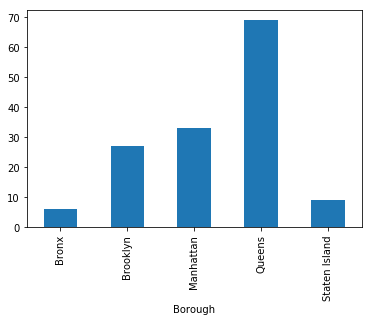

In [15]:
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
print(indian_rest_ny.groupby('Borough')['ID'].count())

Queens has highest number of Indian restaurants

Display Top 5 neighborhood with highest number of Indain restaurants using bar chart

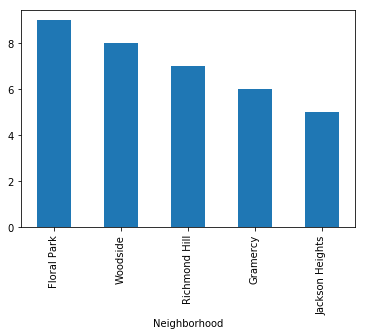

In [14]:
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind="bar")


Floral Park has highest number of indian restaurants

### Fuction to get restaurants details like ratings,tips and likes.

In [17]:
def get_venue_details(ID):
    #print("IN")
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            ID,
            'PAB5Y1MISEQRLLYN112MFJNTXQHKMQ3ZJMNNH0YRN2WGPWNJ', 
            'QJA5JFEPT3QX2GXWKZJNSJTXPSO301RVG5LWKYK2GO1JM3AE', 
            '20200707')
             
               
    results = requests.get(url).json()
    venue_data = results['response']['venue']
    
    venue_details = []
    try:
        venue_id = venue_data['id']
        venue_name = venue_data['name']
        venue_likes = venue_data['likes']['count']
        venue_tips = venue_data['tips']['count']
        venue_rating = venue_data['rating']
        venue_details.append([venue_id,venue_name,venue_likes,venue_tips, venue_rating])    
    except KeyError:
        pass
    
    column_names = ['ID','Name','Likes','Tips','Rating']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#get_venue_details('527d9cbc498edf0db10bde6b')

### Code to create dataframe of all restaurants details.

In [ ]:
column_names=['Borough','Neighborhood','ID','Name','Likes','Tips','Ratings']
indian_rest_ny_data = pd.DataFrame(columns=column_names)
for row in df.values.tolist():
    print(row)
    Borough, Neighborhood, Id, Name = row
    try:
        venue_details = get_venue_details(Id)
        id, name, likes , tips, ratings = venue_details.values.tolist()[0]
        print(id, name, likes , tips, ratings)
    except:
        #When no details available for particular ID
        id,name,likes,tips,ratings=[0]*5
        print("Failure")
        pass
    
    indian_rest_ny_data = indian_rest_ny_data.append({'Borough':Borough,
                                                     'Neighborhood':Neighborhood,
                                                     'ID':id,
                                                     'Name':name,
                                                     'Likes':likes,
                                                     'Tips':tips,
                                                     'Ratings':ratings},
                                                    ignore_index=True)

In [ ]:
Save to Indian Restaaurants details to csv file to reduce API calls.

In [18]:
indian_rest_ny_data = indian_rest_ny_data[indian_rest_ny_data['Name']!=0]
#indian_rest_ny_data.to_csv("Indian_rest.csv")
rest_data = pd.read_csv("Indian_rest.csv")
rest_data = rest_data.drop(["Unnamed: 0"],axis=1)
rest_data

,Borough,Neighborhood,ID,Name,Likes,Tips,Ratings
0,Queens,Astoria,4aa56c81f964a5204e4820e3,Seva Indian Cuisine,239,133,9.0
1,Queens,Woodside,4afdcf29f964a520162b22e3,Rajbhog Sweets,37,25,8.5
2,Queens,Woodside,4c7060e734443704ca0e245f,Kababish,30,18,7.8
3,Queens,Woodside,4b998d3ff964a520fc8235e3,Maharaja Sweets & Snacks,52,25,8.3
4,Queens,Woodside,4b189424f964a52043d423e3,Dera,48,19,7.7
5,Queens,Woodside,5da4fbf091a08400078be19d,Angel Indian Restaurant,11,1,8.0
6,Queens,Woodside,49ebb18ff964a52016671fe3,Delhi Heights,34,24,7.8
7,Queens,Woodside,4e334b7bb0fb17f64f81a8b2,Premium Sweets & Restaurant,11,6,7.4
8,Queens,Woodside,3fd66200f964a52009f11ee3,Jackson Diner,141,78,7.3
9,Queens,Jackson Heights,527d9cbc498edf0db10bde6b,Samudra,49,16,8.7


From all 144 restaurants, Only details of 131 restaurants are available in Foursquare.
So we will the above 131 restaurants data for further analysis

### Find Most Liked Indian restaurants

In [25]:
rest_data.iloc[rest_data['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Tips                                 148
Ratings                              8.6
Name: 104, dtype: object

Tamarind TriBeCa is the most liked Indian restaurants.

### Find Highest rated Indian restaurants

In [40]:
rest_data.iloc[rest_data['Ratings'].idxmax()]

Borough                           Queens
Neighborhood                     Astoria
ID              4aa56c81f964a5204e4820e3
Name                 Seva Indian Cuisine
Likes                                239
Tips                                 133
Ratings                                9
Name: 0, dtype: object

Seva Indian Cuisine in Astoria is the highest rated Indian restaurant.

### Neighborhoods with highest average rating of Indian restaurants.

In [41]:
neighborhood_avg = rest_data.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Ratings']] 
neighborhood_avg = neighborhood_avg.sort_values(['Ratings'],ascending=False).reset_index(drop = True)
print(neighborhood_avg.head(5))

       Neighborhood  Ratings
0           Astoria      9.0
1         Sunnyside      9.0
2        Blissville      9.0
3       Fort Greene      8.8
4  Prospect Heights      8.7


Neighborhoods Astoria, Sunnyside and Blissville has highest average ratings for Indian restaurants  

### Borough with highest average rating of Indian restaurants.

In [42]:
borough_avg = rest_data.groupby('Borough',as_index=False).mean()[['Borough','Ratings']] 
borough_avg = borough_avg.sort_values(['Ratings'],ascending=False).reset_index(drop = True)
borough_avg

,Borough,Ratings
0,Manhattan,8.139394
1,Staten Island,8.000000
2,Brooklyn,7.738462
3,Queens,7.619355
4,Bronx,6.566667


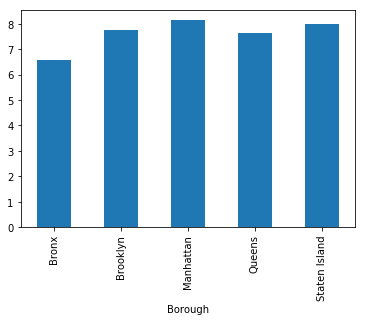

In [43]:
rest_data.groupby('Borough').mean()['Ratings'].plot(kind="bar")

Manhattan has highest averge rating for Indian Restaurants 

### Display highest rated neighborhoods on Map using Folium

In [45]:
best_ny_neigh = pd.merge(neighborhood_avg[0:5],ny_data,on='Neighborhood')
best_ny_neigh

,Neighborhood,Ratings,Borough,Latitude,Longitude
0,Astoria,9.0,Queens,40.768509,-73.915654
1,Sunnyside,9.0,Queens,40.740176,-73.926916
2,Sunnyside,9.0,Staten Island,40.612760,-74.097126
3,Blissville,9.0,Queens,40.737251,-73.932442
4,Fort Greene,8.8,Brooklyn,40.688527,-73.972906
5,Prospect Heights,8.7,Brooklyn,40.676822,-73.964859


In [46]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [47]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in best_ny_neigh[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

for lat, lng,label in best_ny_neigh[['Latitude','Longitude','Neighborhood']].values:
    folium.Marker([lat, lng], popup= label ).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Map showing top 6 neighborhoods with highest average ratings for Indian restaurants. 

### Display Chloropath map of New York based on average Rating of Boroughs 

In [49]:
top_rest = rest_data.sort_values(['Ratings'],ascending=False)
top_rest

,Borough,Neighborhood,ID,Name,Likes,Tips,Ratings
0,Queens,Astoria,4aa56c81f964a5204e4820e3,Seva Indian Cuisine,239,133,9.0
26,Queens,Long Island City,5b931ea69d7468002c3b1382,Adda,129,35,9.0
59,Queens,Blissville,5b931ea69d7468002c3b1382,Adda,129,35,9.0
28,Queens,Sunnyside,5b931ea69d7468002c3b1382,Adda,129,35,9.0
77,Brooklyn,Clinton Hill,57596dad498e732300496b23,Dosa Royale,77,22,8.8
76,Brooklyn,Fort Greene,57596dad498e732300496b23,Dosa Royale,77,22,8.8
110,Manhattan,Gramercy,4a70a75bf964a52016d81fe3,Bhatti Indian Grill,424,161,8.7
80,Brooklyn,Prospect Lefferts Gardens,4bb93b70cf2fc9b6fe64a002,Gandhi Fine Indian Cuisine,82,47,8.7
9,Queens,Jackson Heights,527d9cbc498edf0db10bde6b,Samudra,49,16,8.7
75,Brooklyn,Prospect Heights,592e1dae345cbe0fc77cf6c9,Diwan Grill,16,5,8.7


In [50]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
#ny_map
ny_geo = r'BoroughBoundaries.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=borough_avg,
    columns=['Borough', 'Ratings'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Ratings'
)

# as this is huge map data , we will save it to a file
#ny_map
ny_map.save('borough_rating.jpg')

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Conclusion

#### What is best restaurant  to have Indian food in New York city?
    Best restaurant to have Indian food in New York is "Seva Indian Cuisine" in Astoria neighborhood of Queens.
    
#### Which neighborhoods have good Indian cuisine restaurants?
    Astoria, Sunny Side, Blissville, Fort Greene and Prospect heights are top 5 neighborhoods having good Indian cuisine restaurants

#### Which is the best place to stay if you love Indian food in New York city?
    Manhattan is the best Borough to stay if you love Indian food in New York city.